## Importing Libraries

In [ ]:
from google.colab import drive
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from hashlib import sha256
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential , Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

### Mounting the Data

In [ ]:
drive.mount('/content/drive')
folder_path = '/content/drive/MyDrive/brain_tumor_dataset'
print("Folder contents:", os.listdir(folder_path))

Mounted at /content/drive
Folder contents: ['yes', 'no']


## Data Visualization

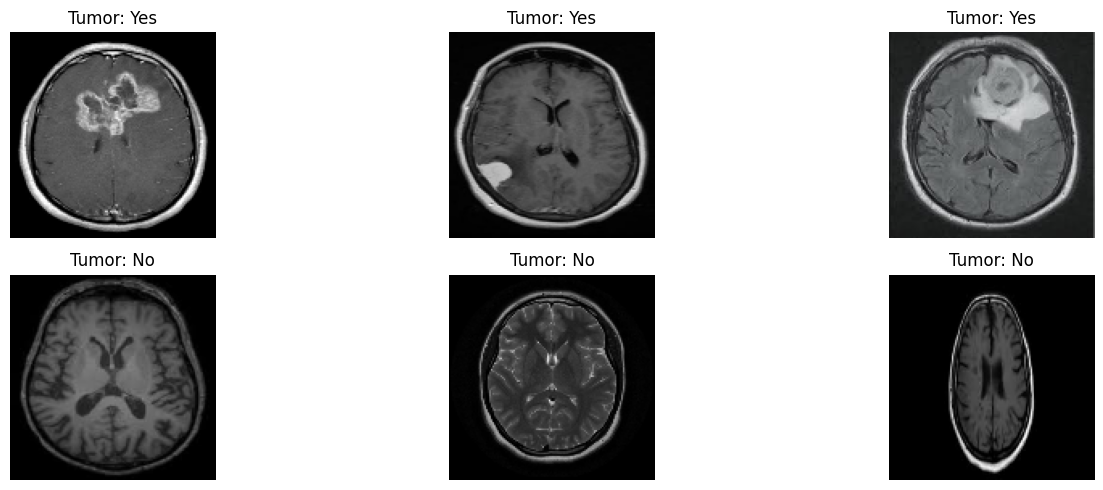

In [ ]:
path_no= '/content/drive/MyDrive/brain_tumor_dataset/no/*'
path_yes= '/content/drive/MyDrive/brain_tumor_dataset/yes/*'

tumor = []
no_tumor = []
random_state = 42

for file in glob.iglob(path_yes):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    tumor.append((img, 1))

for file in glob.iglob(path_no):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    no_tumor.append((img, 0))

all_data = tumor + no_tumor

data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

plt.figure(figsize=(15, 5))

for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(tumor[i][0])
    plt.title("Tumor: Yes")
    plt.axis('off')

for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(no_tumor[i][0])
    plt.title("Tumor: No")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Distribution of Classes

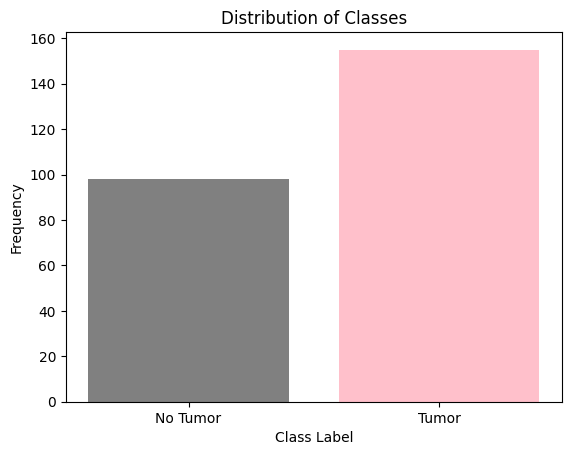

In [ ]:
unique_labels, label_counts = np.unique(labels, return_counts=True)
plt.bar(unique_labels, label_counts, color=['gray', 'pink'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Distribution of Classes')
plt.show()

### Pixel Intensity Histogram

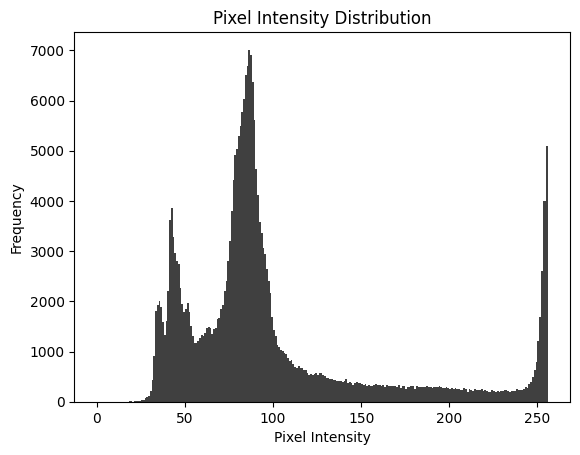

In [ ]:
random_image= '/content/drive/MyDrive/brain_tumor_dataset/yes/Y180.jpg'
image = Image.open(random_image).convert('L')
pixel_values = np.array(image).flatten()
plt.hist(pixel_values, bins=256, range=(0,256), color='black', alpha=0.75)
plt.title('Pixel Intensity Distribution')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

### Width and Height Distribution

Average Width: 438.58 pixels
Average Height: 491.83 pixels


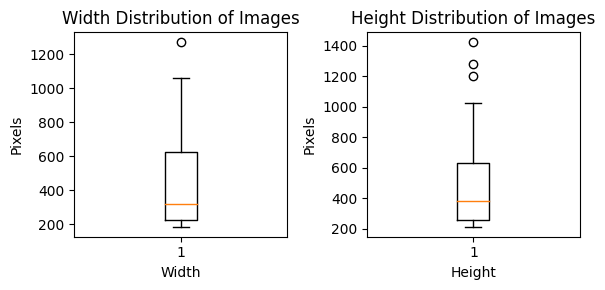

In [ ]:
directory = '/content/drive/MyDrive/brain_tumor_dataset/yes'

widths = []
heights = []

for filename in os.listdir(directory):
    if filename.endswith(".jpg"):
        image_path = os.path.join(directory, filename)
        with Image.open(image_path) as img:
            width, height = img.size
            widths.append(width)
            heights.append(height)

average_width = sum(widths) / len(widths)
average_height = sum(heights) / len(heights)

print(f"Average Width: {average_width:.2f} pixels")
print(f"Average Height: {average_height:.2f} pixels")

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.boxplot(widths)
plt.title('Width Distribution of Images')
plt.ylabel('Pixels')
plt.xlabel('Width')

plt.subplot(1, 2, 2)
plt.boxplot(heights)
plt.title('Height Distribution of Images')
plt.ylabel('Pixels')
plt.xlabel('Height')

plt.tight_layout()
plt.show()

## Data Cleaning



Found 25 duplicates.
Examples of duplicate files:
Duplicate: /content/drive/MyDrive/brain_tumor_dataset/yes/Y13.jpg is a duplicate of /content/drive/MyDrive/brain_tumor_dataset/yes/Y169.jpg
Duplicate: /content/drive/MyDrive/brain_tumor_dataset/yes/Y108.jpg is a duplicate of /content/drive/MyDrive/brain_tumor_dataset/yes/Y162.jpg
Duplicate: /content/drive/MyDrive/brain_tumor_dataset/yes/Y31.jpg is a duplicate of /content/drive/MyDrive/brain_tumor_dataset/yes/Y62.jpg
Duplicate: /content/drive/MyDrive/brain_tumor_dataset/yes/Y34.jpg is a duplicate of /content/drive/MyDrive/brain_tumor_dataset/yes/Y15.jpg
Duplicate: /content/drive/MyDrive/brain_tumor_dataset/yes/Y17.jpg is a duplicate of /content/drive/MyDrive/brain_tumor_dataset/yes/Y14.jpg


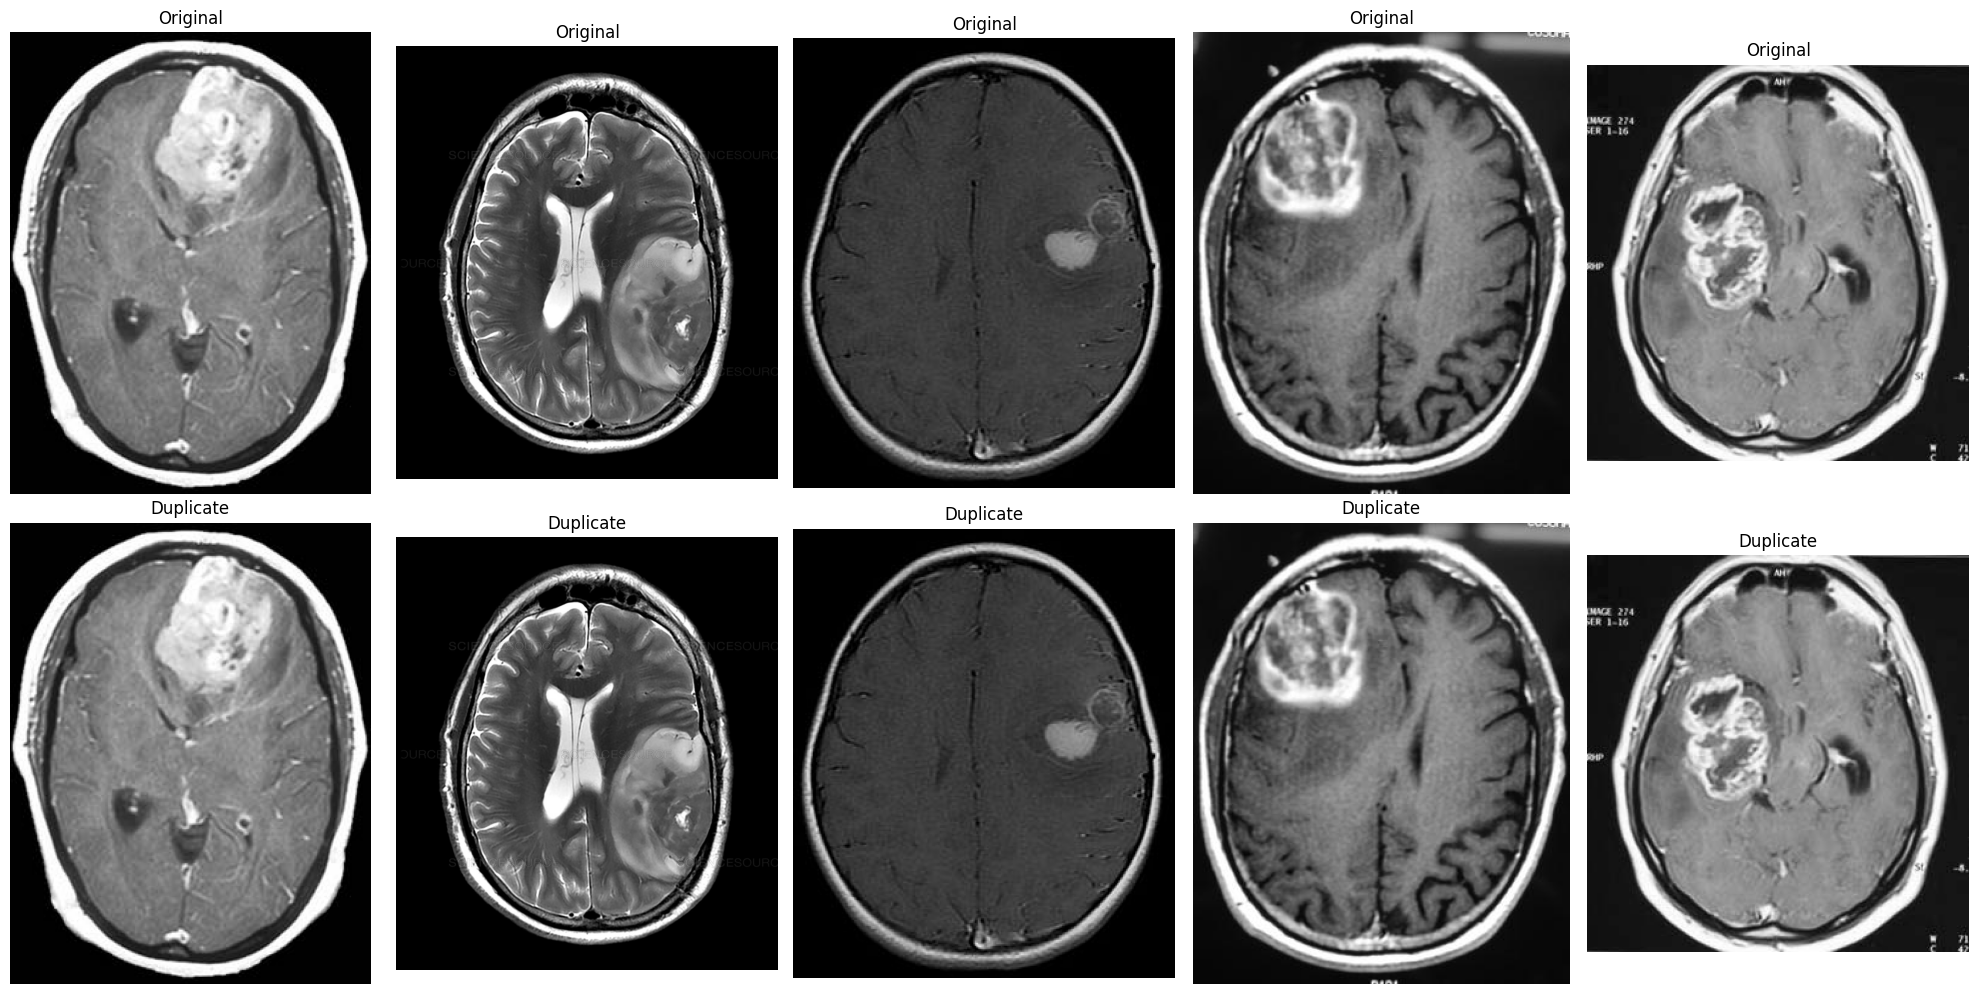

In [ ]:
def image_hash(image):
    return sha256(image.tobytes()).hexdigest()

all_data = []
for file in glob.glob(path_yes):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    all_data.append((img, 1, file))

for file in glob.glob(path_no):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    all_data.append((img, 0, file))

hashes = {}
duplicates = []

for index, (img, label, path) in enumerate(all_data):
    img_hash = image_hash(img)
    if img_hash in hashes:
        duplicates.append((path, hashes[img_hash][0]))
    else:
        hashes[img_hash] = (path, index)

print(f"Found {len(duplicates)} duplicates.")
if duplicates:
    print("Examples of duplicate files:")
    for dup in duplicates[:5]:  # Display first 5 duplicates
        print(f"Duplicate: {dup[0]} is a duplicate of {dup[1]}")

plt.figure(figsize=(20, 10))
num_duplicates = min(5, len(duplicates))

for i, dup in enumerate(duplicates[:num_duplicates]):
    original_img = cv2.imread(dup[1])
    duplicate_img = cv2.imread(dup[0])
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    duplicate_img = cv2.cvtColor(duplicate_img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, num_duplicates, i + 1)
    plt.imshow(original_img)
    plt.title("Original")
    plt.axis('off')

    plt.subplot(2, num_duplicates, i + num_duplicates + 1)
    plt.imshow(duplicate_img)
    plt.title("Duplicate")
    plt.axis('off')

plt.tight_layout()
plt.show()

### Removing Duplicates

In [ ]:
for dup in duplicates:
    os.remove(dup[0])
    print(f"Removed duplicate file: {dup[0]}")

Removed duplicate file: /content/drive/MyDrive/brain_tumor_dataset/yes/Y13.jpg
Removed duplicate file: /content/drive/MyDrive/brain_tumor_dataset/yes/Y108.jpg
Removed duplicate file: /content/drive/MyDrive/brain_tumor_dataset/yes/Y31.jpg
Removed duplicate file: /content/drive/MyDrive/brain_tumor_dataset/yes/Y34.jpg
Removed duplicate file: /content/drive/MyDrive/brain_tumor_dataset/yes/Y17.jpg
Removed duplicate file: /content/drive/MyDrive/brain_tumor_dataset/yes/Y38.jpg
Removed duplicate file: /content/drive/MyDrive/brain_tumor_dataset/yes/Y54.jpg
Removed duplicate file: /content/drive/MyDrive/brain_tumor_dataset/yes/Y10.jpg
Removed duplicate file: /content/drive/MyDrive/brain_tumor_dataset/yes/Y70.jpg
Removed duplicate file: /content/drive/MyDrive/brain_tumor_dataset/yes/Y181.jpg
Removed duplicate file: /content/drive/MyDrive/brain_tumor_dataset/yes/Y25.jpg
Removed duplicate file: /content/drive/MyDrive/brain_tumor_dataset/yes/Y74.jpg
Removed duplicate file: /content/drive/MyDrive/bra

### Removing Corrupt Images

In [ ]:
path_yes = '/content/drive/MyDrive/brain_tumor_dataset/yes/*'
path_no = '/content/drive/MyDrive/brain_tumor_dataset/no/*'

def check_images(path):
    corrupt_files = []
    for file in glob.glob(path):
        img = cv2.imread(file)
        if img is None:
            print(f"Corrupt image found: {file}")
            corrupt_files.append(file)
    return corrupt_files

corrupt_yes = check_images(path_yes)
corrupt_no = check_images(path_no)

for file in corrupt_yes + corrupt_no:
    os.remove(file)
    print(f"Removed corrupt file: {file}")


### Normalization, Shuffling, and Splitting

In [ ]:
path_no = '/content/drive/MyDrive/brain_tumor_dataset/no/*'
path_yes = '/content/drive/MyDrive/brain_tumor_dataset/yes/*'

tumor = []
no_tumor = []
random_state = 42

for file in glob.iglob(path_yes):
    img = cv2.imread(file)
    if img is None:
        print(f"Failed to load image: {file}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    tumor.append((img, 1))

for file in glob.iglob(path_no):
    img = cv2.imread(file)
    if img is None:
        print(f"Failed to load image: {file}")
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    no_tumor.append((img, 0))

all_data = tumor + no_tumor

print("Total images in 'tumor':", len(tumor))
print("Total images in 'no_tumor':", len(no_tumor))
print("Total images loaded:", len(all_data))

data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

# Normalize the data
data = data.astype('float32') / 255.0

print("Data shape:", data.shape)
print("Labels shape:", labels.shape)

# Shuffle the dataset
indices = np.random.permutation(len(data))
data = data[indices]
labels = labels[indices]

# Reshape data for CNN input
data = data.reshape(-1, 128, 128, 3)

# Splitting the dataset into training, validation, and test sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.20, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(test_data, test_labels, test_size=0.50, random_state=42)


print("Training data shape:", train_data.shape)
print("Validation data shape:", val_data.shape)
print("Test data shape:", test_data.shape)
print("Training labels shape:", train_labels.shape)
print("Validation labels shape:", val_labels.shape)
print("Test labels shape:", test_labels.shape)

Total images in 'tumor': 141
Total images in 'no_tumor': 87
Total images loaded: 228
Data shape: (228, 128, 128, 3)
Labels shape: (228,)
Training data shape: (182, 128, 128, 3)
Validation data shape: (23, 128, 128, 3)
Test data shape: (23, 128, 128, 3)
Training labels shape: (182,)
Validation labels shape: (23,)
Test labels shape: (23,)


## Data Augmentation

In [ ]:
data_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
unique, counts = np.unique(train_labels, return_counts=True)
print(dict(zip(unique, counts)))

{0: 74, 1: 108}


## Model Architecture

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), padding='same', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(0.01)),
    MaxPooling2D((2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

# Compile model
optimizer = Adam(learning_rate=0.0001)
model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy', Precision(), Recall()])

print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 64, 64, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_41 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_42 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 32, 32, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_42 (Dropout)        (None, 32, 32, 64)      

In [ ]:
train_labels.shape

(159,)

## Model Training with Callbacks

In [ ]:
checkpoint_path = "best_model.h5"
early_stopping_patience = 10
checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, mode='min', verbose=1)

history = model.fit(train_data, train_labels, epochs=50, batch_size=32, validation_data=(val_data, val_labels),
                    callbacks=[checkpoint, early_stopping])


Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 1.2840 - accuracy: 0.8242 - precision_2: 0.8182 - recall_2: 0.9310
Epoch 1: val_loss improved from inf to 1.40491, saving model to best_model.h5
6/6 [==============================] - 13s 2s/step - loss: 1.2840 - accuracy: 0.8242 - precision_2: 0.8182 - recall_2: 0.9310 - val_loss: 1.4049 - val_accuracy: 0.8261 - val_precision_2: 0.7500 - val_recall_2: 1.0000
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: 1.2824 - accuracy: 0.8352 - precision_2: 0.8308 - recall_2: 0.9310
Epoch 2: val_loss improved from 1.40491 to 1.38332, saving model to best_model.h5
6/6 [==============================] - 10s 2s/step - loss: 1.2824 - accuracy: 0.8352 - precision_2: 0.8308 - recall_2: 0.9310 - val_loss: 1.3833 - val_accuracy: 0.8261 - val_precision_2: 0.7500 - val_recall_2: 1.0000
Epoch 3/50
6/6 [==============================] - ETA: 0s - loss: 1.2544 - accuracy: 0.8187 - precision_2: 0.8320 - recall_2: 0.8966
Epoch 3

### Training Accuracy

In [ ]:
train_accuracy = history.history['accuracy']
print("Training Accuracy per Epoch:", train_accuracy)

Training Accuracy per Epoch: [0.8241758346557617, 0.8351648449897766, 0.8186812996864319, 0.8186812996864319, 0.8186812996864319, 0.8296703100204468, 0.8021978139877319, 0.8186812996864319, 0.8516483306884766, 0.8626373410224915, 0.8296703100204468, 0.8351648449897766, 0.8461538553237915, 0.8681318759918213, 0.807692289352417, 0.8461538553237915, 0.8626373410224915, 0.8736263513565063, 0.8681318759918213, 0.8681318759918213, 0.8846153616905212, 0.8571428656578064, 0.8626373410224915, 0.8571428656578064, 0.8791208863258362, 0.8736263513565063, 0.8846153616905212, 0.8791208863258362, 0.8901098966598511, 0.9175823926925659, 0.8846153616905212, 0.8791208863258362, 0.8901098966598511, 0.8901098966598511, 0.8791208863258362, 0.901098906993866, 0.9230769276618958, 0.901098906993866, 0.9340659379959106, 0.906593382358551, 0.906593382358551]


## Test Scores

In [ ]:
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_data, test_labels)
print('Test accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)

1/1 [==============================] - 0s 235ms/step - loss: 0.7932 - accuracy: 0.9565 - precision_2: 0.9286 - recall_2: 1.0000
Test accuracy: 0.95652174949646
Test precision: 0.9285714030265808
Test recall: 1.0


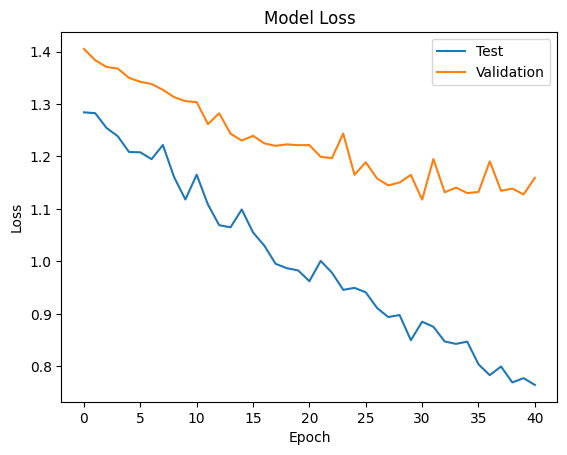

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Test', 'Validation'], loc='upper right')
plt.show()

In [ ]:
probabilities = model.predict(test_data)
predictions = (probabilities > 0.5).astype(int)

1/1 [==============================] - 0s 490ms/step


## Confusion Matrix

In [ ]:
true_labels = test_labels

cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:\n", cm)

## AUC, Precision, Recall, F1 Score

In [ ]:
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.9565217391304348
Precision: 0.9285714285714286
Recall: 1.0
F1 Score: 0.962962962962963


## ROC Curve

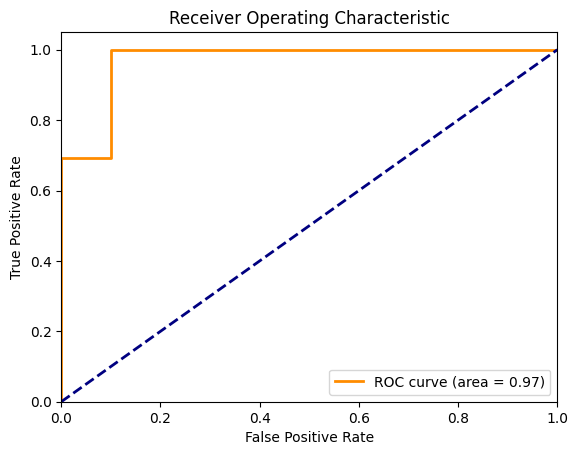

In [ ]:
fpr, tpr, thresholds = roc_curve(true_labels, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Intersection Over Union (IOU)

In [ ]:
def compute_iou(box1, box2):

    x1, y1, x2, y2 = box1
    x1_p, y1_p, x2_p, y2_p = box2

    xi1 = max(x1, x1_p)
    yi1 = max(y1, y1_p)
    xi2 = min(x2, x2_p)
    yi2 = min(y2, y2_p)

    inter_area = max(xi2 - xi1, 0) * max(yi2 - yi1, 0)

    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)

    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area
    return iou

box1 = [100, 100, 200, 200]
box2 = [150, 150, 250, 250]
iou = compute_iou(box1, box2)
print("IOU:", iou)


IOU: 0.14285714285714285


## Transfer Learning Using VGG-16

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)  #
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output_layer)

model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [ ]:
#Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    verbose=1,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'vgg-26-fine-tuned.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=0.00001
)


In [ ]:
#training
train_generator = train_datagen.flow(train_data, train_labels, batch_size=32)
history = model.fit(
    train_generator,  y
    epochs=10,
    validation_data=(val_data, val_labels),
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/10
6/6 [==============================] - ETA: 0s - loss: 0.4664 - accuracy: 0.8132
Epoch 1: val_loss did not improve from 0.20310
6/6 [==============================] - 41s 7s/step - loss: 0.4664 - accuracy: 0.8132 - val_loss: 0.4913 - val_accuracy: 0.7826 - lr: 1.2500e-04
Epoch 2/10
6/6 [==============================] - ETA: 0s - loss: 0.3933 - accuracy: 0.8187
Epoch 2: val_loss did not improve from 0.20310
6/6 [==============================] - 42s 7s/step - loss: 0.3933 - accuracy: 0.8187 - val_loss: 0.4225 - val_accuracy: 0.7826 - lr: 1.2500e-04
Epoch 3/10
6/6 [==============================] - ETA: 0s - loss: 0.3357 - accuracy: 0.8516
Epoch 3: val_loss did not improve from 0.20310
6/6 [==============================] - 37s 6s/step - loss: 0.3357 - accuracy: 0.8516 - val_loss: 0.2501 - val_accuracy: 0.8696 - lr: 1.2500e-04
Epoch 4/10
6/6 [==============================] - ETA: 0s - loss: 0.3255 - accuracy: 0.8571
Epoch 4: val_loss did not improve from 0.20310
6/6 [=======

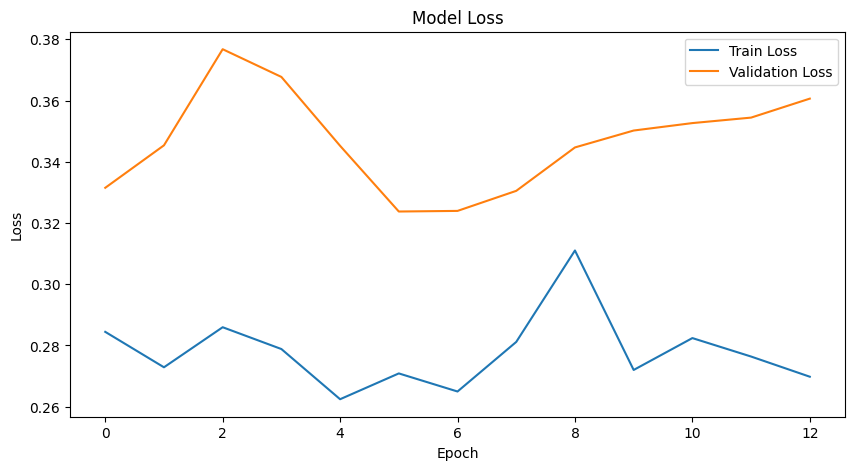

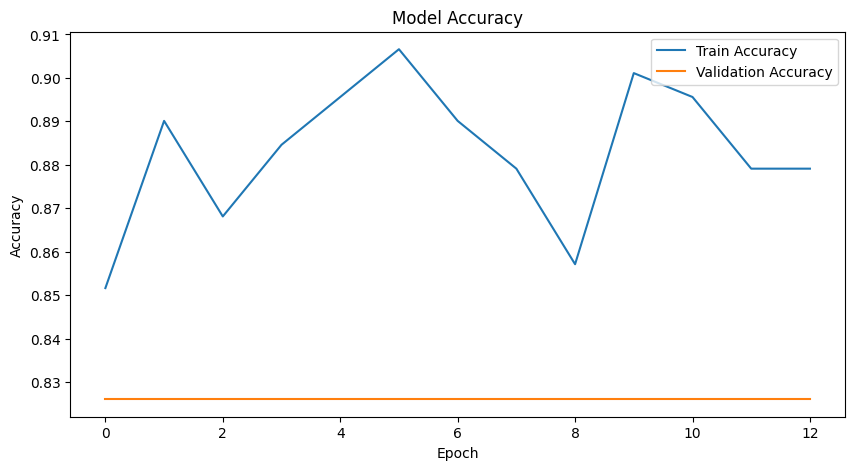

In [ ]:
#plotting
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#confusion matrix

probabilities = model.predict(test_data)
predictions = (probabilities > 0.5).astype(int)
true_labels = test_labels
cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:\n", cm)


1/1 [==============================] - 5s 5s/step
Confusion Matrix:
 [[ 7  4]
 [ 0 12]]


In [ ]:
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8260869565217391
Precision: 0.75
Recall: 1.0
F1 Score: 0.8571428571428571


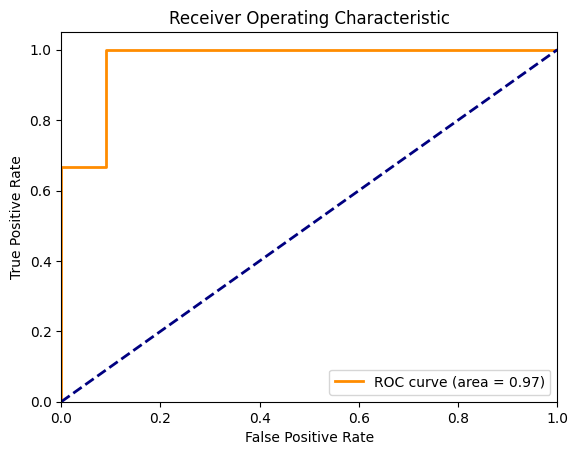

In [ ]:
# ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Testing by Giving Input Image

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

image_path = '/content/drive/MyDrive/brain_tumor_dataset/no/11 no.jpg'
img = load_img(image_path, target_size=(128, 128))
img_array = img_to_array(img)
img_array = img_array / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make a prediction
predictions = model.predict(img_array)

# Assuming a binary classification model with a sigmoid activation
predicted_class = int(predictions[0][0] > 0.5)
print("Predicted class:", predicted_class)



1/1 [==============================] - 0s 499ms/step
Predicted class: 0
